# Experiment 6: Indirect-contrl ZNE with ideal noise-free time-evolution gate
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse filed Ising Hamiltonian.
- Ansatz time-evolution: Heisenberg-Hamiltonian.

## (1) Imports and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 11

## (2) Loading experimental data

The raw experimental are available at `experimental data/data`. The following code parses the ZNE data:

In [3]:
# Folder containing your JSON files
folder_path = "experimental data/data"

# List to store the data from the filtered JSON files
all_zne_data = []
noise_free_data = []
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "ZNE" in filename:  # Check if the file is a JSON file and contains "ZNE"
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            all_zne_data.append(data)  # Add the parsed data to the list
    elif filename.endswith(".json") and "ZNE" in filename:  # Check if the file is a JSON file and contains "ZNE"
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            all_zne_data.append(data)  # Add the parsed data to the list

## (3) Extracting experimental outcomes

To extract other useful data such as exact minimum eigen values, estimated minimum eigen values etc, the VQE data needs to be parsed.

In [4]:
# List to store the data from the filtered JSON files
vqe_data = []
noiseless_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "VQE" in filename:  # Check if the file is a JSON file and contains "ZNE"
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            vqe_data.append(data)  # Add the parsed data to the list
    elif filename.endswith(".json") and "noisefree_vqe" in filename:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            noiseless_data.append(data)  # Add the parsed data to the list

### (A) Exact minimum eigen value

In [5]:
exact_sol = vqe_data[0]["output"]["exact_sol"]
print(f"Exact sol: {exact_sol}")

Exact sol: -8.56677223350563


### (B) Noise-free ansatz data

In [6]:
noisefree_estimation = noiseless_data[0]["Optimized_minimum_cost"]
noisefree_mean = np.mean(noisefree_estimation)
print(f"Noise-free mean estimation: {noisefree_mean}")

Noise-free mean estimation: -8.450217972952293


### (C) Unmitigated data from noisy standard ansatz

Unmitigated expectation values are recodred in `filenameprefix_VQE.json` file under the key `optimized_minimum_cost`.

In [7]:
unmitigated_eigen_vals = vqe_data[0]["output"]["optimized_minimum_cost"]
unmitigated_eigen_vals_mean = np.mean(unmitigated_eigen_vals)
print(f"Unmitigated noisy mean estimation: {unmitigated_eigen_vals_mean}")

Unmitigated noisy mean estimation: -5.309993052858839


In [8]:
# Standard deviation in eigenvalues
unmitigated_eigen_vals_sd = np.std(unmitigated_eigen_vals)
print(f"Unmitigated noisy standard deviation: {unmitigated_eigen_vals_sd}")

Unmitigated noisy standard deviation: 0.089912838888468


In [9]:
noisefree_sd = np.std(noisefree_estimation)
print(f"Noise-free standard deviation: {noisefree_sd}")

Noise-free standard deviation: 0.06830077032241505


In [10]:
noise_prob = vqe_data[0]["config"]["vqe"]["ansatz"]["noise"]["value"]

### (D) Noise-Boosted Redundant Ansatz Data

Two-point Richardson extrapolation was performed for ZNE. The noise levels at these two points were (6, 16), where the first value corresponds to the unboosted noise level and the second value represents the boosted noise level. These values are available in the ZNE data files (`somefilenameprefix_ZNE.json`) under the `sorted_noise` key.  

**How is noise boosted?**  

The noise level in the circuit is artificially boosted using _identity scaling_. For any noisy quantum gate $G$, a noisy identity $G^{\dagger}G$ is inserted into the circuit. The number of identities to be inserted is determined by the `identity_factors` specified in the configuration file.  

**WARNING:** Identity scaling for time evolution works only when `ansatz.type: 'xy-iss'`.  

**How are these noise levels calculated?**  

The noise level is a quantity proportional to the number of noisy gates in each layer of the ansatz. It is defined as `[nR, nT, nY, nCZ]`, where each value is proportional to the number of rotation gates, time-evolution gates, Pauli-Y gates, and CZ gates, respectively. These values, along with the corresponding energy estimations $E$, are available in the ZNE data files (`somefilenameprefix_ZNE.json`) under the `data_points` key as `[nR, nT, nY, nCZ, E]`.  

For multivariate extrapolation methods, such as `richardson-mul` or `polynomial`, `[nR, nT, nY, nCZ]` are treated as independent variables, with the corresponding energy value `E` serving as the dependent variable. In contrast, for `richardson`, a univariate method, the noise level is defined as the sum: `sum(nR, nT, nY, nCZ)`.  

In [11]:
boosted_noisy_expectation_list = []  # Stores pairs of expectation values corresponding to noise level 16 (boosted form 6 to 16)

for data in all_zne_data:
    boosted_noisy_expectation_vals = data["output"]["zne_values"]["others"]["sorted_expectation_vals"][-1]  # List containing expectation values [val1, val2] for noise levels 6 and 16.
    boosted_noisy_expectation_list.append(boosted_noisy_expectation_vals)

boosted_noisy_expectation_val_mean = np.mean(boosted_noisy_expectation_list)    # Mean expected value at boosted noise 16
boosted_noisy_expectation_val_sd = np.std(boosted_noisy_expectation_list)

# Printing the means and standard deviations
print(f"Mean expectation value at noise level 16: {boosted_noisy_expectation_val_mean}")
print(f"Standard deviation at noise level 16: {boosted_noisy_expectation_val_sd}")


Mean expectation value at noise level 16: -2.6862902615410693
Standard deviation at noise level 16: 0.11839682024679604


### (E) ZNE data: Mean and standard deviation of ZNE values

In [12]:
zne_vals = []
for data in all_zne_data:
    zne_val = data["output"]["zne_values"]["extrapolated_value"]
    zne_vals.append(zne_val)

zne_mean = np.mean(zne_vals)
print(f"ZNE mean: {zne_mean}")


ZNE mean: -6.8842147276495


In [13]:
zne_sd = np.std(zne_vals)
print(f"ZNE standard deviation: {zne_sd}")

ZNE standard deviation: 0.09344990918566992


## (4) Plotting result

Finally, we plot the results.

### (A) Comparison between unmitigated, ZNE mitigated, and noise-free

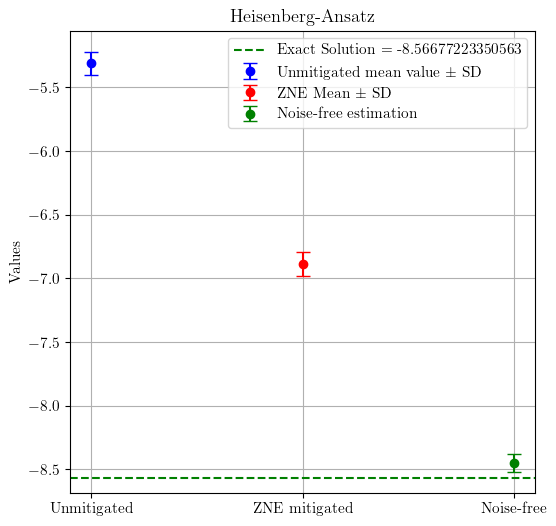

In [14]:
# Data labels
labels = ["Unmitigated", "ZNE mitigated", "Noise-free"]

# Values to plot
means = [unmitigated_eigen_vals_mean, zne_mean, noisefree_mean]
sds = [unmitigated_eigen_vals_sd, zne_sd, noisefree_sd]

# Create the plot with error bars
plt.figure(figsize=(6, 6))

# Plot eigenvalues with error bars
plt.errorbar(labels[0], means[0], yerr=sds[0], fmt="o", color="blue", capsize=5, label="Unmitigated mean value ± SD")

# Plot ZNE values with error bars
plt.errorbar(labels[1], means[1], yerr=sds[1], fmt="o", color="red", capsize=5, label="ZNE Mean ± SD")

# Plot ZNE values with error bars
plt.errorbar(labels[2], means[2], yerr=sds[2], fmt="o", color="green", capsize=5, label="Noise-free estimation")

# Plot the horizontal line for the exact solution
plt.axhline(y=exact_sol, color="green", linestyle="--", label=f"Exact Solution = {exact_sol}")

# Adding title and labels
plt.title(f"Heisenberg-Ansatz")
plt.ylabel("Values")
plt.grid(True)
# Add a legend
plt.legend()
plt.show()